In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np
import scipy

from mflex.simulate.simulate_boundary import dalmatian

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield
from mhsflex.vis import plot, plot_plasma_parameters, show_poles, show_footpoints
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt
from scipy.io import readsav


rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c4 = (1.000, 0.224, 0.376)
c1 = (0.439, 0.788, 1.000)
c3 = "black"
c2 = (0.420, 0.502, 1.000)

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

cmap2 = colors.LinearSegmentedColormap.from_list(
    "cmap2", ((0.000, (0.984, 1.000, 0.000)), (1.000, (1.000, 0.988, 0.761)))
)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path = "/Users/lilli/Desktop/mflex/data/RMHD_boundary_data.sav"

data = readsav(path, python_dict=True, verbose=True)

--------------------------------------------------
Date: Tue Sep  6 15:18:26 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 10 records of which:
 - 6 are of type VARIABLE
 - 1 are of type NOTICE
 - 1 are of type TIMESTAMP
 - 1 are of type VERSION
--------------------------------------------------
Available variables:
 - b2dx [<class 'numpy.ndarray'>]
 - b2dy [<class 'numpy.ndarray'>]
 - b2dz [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------


In [4]:
data_bz = data["b2dz"]
data_bx = data["b2dx"]
data_by = data["b2dy"]

nresol_x = data_bz.shape[1]
nresol_y = data_bz.shape[0]

pixelsize_z_Mm = 64.0 * 10**-3  # Convert pixelsize from km into Mm
pixelsize_x_Mm = 192.0 * 10**-3
pixelsize_y_Mm = 192.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

xmax_Mm = nresol_x * pixelsize_x_Mm
ymax_Mm = nresol_y * pixelsize_y_Mm
zmax_Mm = 41.6

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

deltaz = z0 / 10

nf_max = min(nresol_x, nresol_y)

print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x", pixelsize_x_Mm)
print("pixelsize_y", pixelsize_y_Mm)
print("pixelsize_z", pixelsize_z_Mm)

xmax_Mm, ymax_Mm, zmax_Mm 98.304 49.152 41.6
nresol_x, nresol_y, nresol_z 512 256 650
pixelsize_x 0.192
pixelsize_y 0.192
pixelsize_z 0.064


In [5]:
data_bz.min()

-3081.8796

In [6]:
x_arr = np.arange(nresol_x) * (xmax_Mm - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax_Mm - ymin) / (nresol_y - 1) + ymin
z_arr = np.arange(nresol_z) * (zmax_Mm - zmin) / (nresol_z - 1) + zmin
x_grid, y_grid = np.meshgrid(x_arr, y_arr)

In [7]:
data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nf_max,
    pixelsize_x_Mm,
    pixelsize_y_Mm,
    pixelsize_z_Mm,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [13]:
np.sum(data2d.bz)/np.sum(np.fabs(data2d.bz))

-0.0071758144

In [14]:
Jz = np.gradient(data_by, axis=1) - np.gradient(data_bx, axis=0)
alpha = np.sum(Jz * np.sign(data_bz)) / np.sum(np.fabs(data_bz))
alpha

0.010229302

In [15]:
alpha = alpha

length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * pixelsize_x_Mm
length_scale_y = 2.0 * nresol_y * pixelsize_y_Mm

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(nf_max) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(nf_max) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(nf_max) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2


# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - (2 * alpha) ** 2) / (2 * k2_arr)

print(limit.min())

0.2950893174471233


In [9]:
folder = "/Users/lilli/Desktop/Thesis/ISSIRMHD"

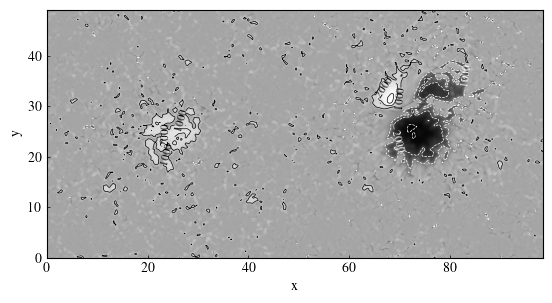

In [20]:
norm = colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)
fig = plt.figure()
ax = fig.add_subplot(111)

ax.contourf(
    x_grid,
    y_grid,
    data2d.bz,
    1000,
    cmap=cmap, 
    #norm=norm,
)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-3000, -2000, -1000)),
    colors="white",
    linewidths=0.5,
)
CS2 = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((1000, 2000, 3000)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=8, inline=True)
ax.clabel(CS2, fontsize=8, inline=True)
ax.set_box_aspect(ymax_Mm / xmax_Mm)
ax.tick_params(direction="in", length=2, width=0.5)
plotname =  folder + "/contourcombi.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

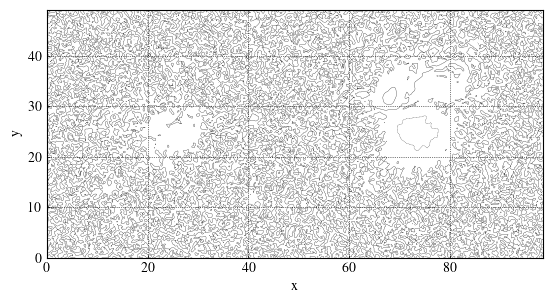

In [10]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    2,
    colors="k",
    linewidths=0.2,
)
ax.grid(color="black", alpha=1.0, linestyle="dotted", linewidth=0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_box_aspect(ymax_Mm / xmax_Mm)
# ax.clabel(CS, fontsize=8, inline=True)
ax.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/contour.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
norm = colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.grid(color="white", alpha=1.0, linestyle="dotted", linewidth=0.5)
ax.contourf(x_grid, y_grid, data2d.bz, 1000, cmap=cmap)
ax.set_box_aspect(data2d.y[-1] / data2d.x[-1])
ax.tick_params(direction="in", length=2, width=0.5)
ax.set_xlabel("x")
ax.set_ylabel("y")
plotname = folder + "/contour3.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [11]:
data3d = calculate_magfield(data2d, 0.46, 1.0, 0.004, z0, deltaz)
path2saveMHS3 = "/Users/lilli/Desktop/mflex/ISSIRMHD/MHS3"
data3d.save(path2saveMHS3)

KeyboardInterrupt: 

In [ ]:
plot(data3d, "angular", False, True, path=folder)
plot(data3d, "side", False, True, path=folder)
plot(data3d, "los", False, True, path=folder)

In [6]:
# data3dmhs2 = calculate_magfield(data2d, 0.3, 1.0, 0.01, z0, deltaz)

path2saveMHS2 = "/Users/lilli/Desktop/mflex/ISSIRMHD/MHS2"
# data3dmhs2.save(path2saveMHS2)

data3dmhs2 = Field3dData.load(path2saveMHS2)

In [ ]:
plot(data3dmhs2, "los")

In [12]:
# data3dmhs1 = calculate_magfield(data2d, 0.15, 1.0, 0.01, z0, deltaz)

path2saveMHS1 = "/Users/lilli/Desktop/mflex/ISSIRMHD/MHS1"
# data3dmhs1.save(path2saveMHS1)

data3dmhs1 = Field3dData.load(path2saveMHS1)

KeyboardInterrupt: 

In [18]:
# data3dpot = calculate_magfield(data2d, 0.0, 1.0, 0.0, z0, deltaz)

path2savepot = "/Users/lilli/Desktop/mflex/ISSIRMHD/Potential"
# # data3dpot.save(path2savepot)

data3dpot = Field3dData.load(path2savepot)

In [13]:
# data3dlff = calculate_magfield(data2d, 0.0, 1.0 , 0.01, z0, deltaz)

path2saveLFF = "/Users/lilli/Desktop/mflex/ISSIRMHD/LFF"
# data3dlff.save(path2saveLFF)

data3dlff = Field3dData.load(path2saveLFF)

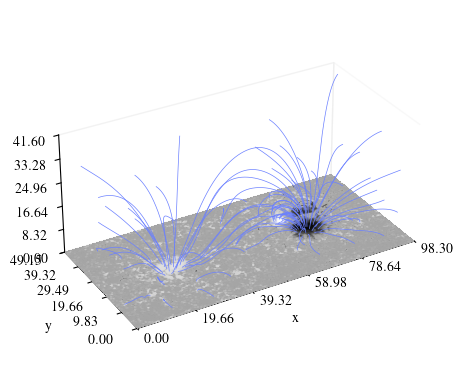

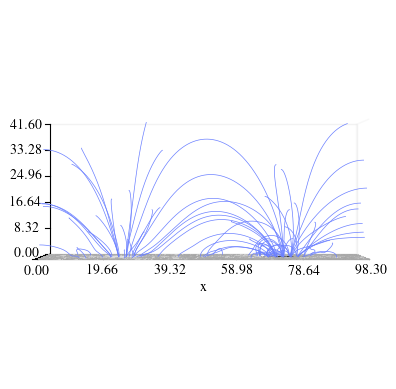

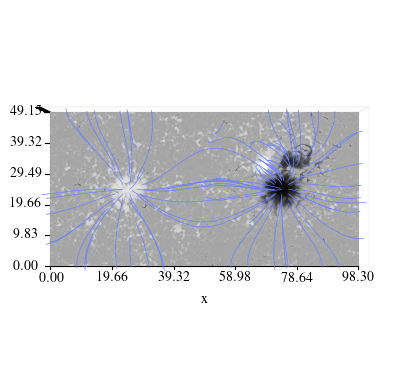

In [21]:
plot(data3dlff, "angular", False, True, path=folder)
plot(data3dlff, "side", False, True, path=folder)
plot(data3dlff, "los", False, True, path=folder)

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    3,
    colors="k",
    linewidths=0.2,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
# ax.clabel(CS, fontsize=5, inline=True)
ax.set_box_aspect(ymax_Mm / xmax_Mm)
ax.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/contour.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
CS = ax.contour(
    x_grid,
    y_grid,
    data2d.bz,
    levels=np.array((-2000, -500, 500, 2000)),
    colors="k",
    linewidths=0.5,
)
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.clabel(CS, fontsize=5, inline=True)
ax.set_box_aspect(ymax_Mm / xmax_Mm)
ax.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/contour2.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
show_poles(data3dmhs2)

In [ ]:
show_footpoints(data3dmhs2)

In [ ]:
plot(data3dlff, "angular", False, True, path=folder)
plot(data3dlff, "side", False, True, path=folder)
plot(data3dlff, "los", False, True, path=folder)

In [7]:
path3dref = "/Users/lilli/Desktop/mflex/data/RMHD_3D_data.sav"
data3dref = scipy.io.readsav(path3dref, python_dict=True, verbose=True)

print(data3dref["info_unit"])
print(data3dref["info_pixel"])
print(data3dref["info_array"])

bx_ref = data3dref["b3dx"]
by_ref = data3dref["b3dy"]
bz_ref = data3dref["b3dz"]

pres_3d = data3dref["p3d"] * 10**-1
den_3d = data3dref["d3d"] * 10**3

bx_rec = data3dmhs2.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 1]
by_rec = data3dmhs2.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 0]
bz_rec = data3dmhs2.field[nresol_y : 2 * nresol_y, nresol_x : 2 * nresol_x, :, 2]
print(bx_rec.shape)
print(by_rec.shape)
print(bz_rec.shape)

issi_bx = np.zeros_like(bx_rec)
issi_by = np.zeros_like(by_rec)
issi_bz = np.zeros_like(bz_rec)

for i in range(0, nresol_y):
    for j in range(0, nresol_x):
        for k in range(0, nresol_z):
            issi_bx[i, j, k] = bx_ref[k, i, j]
            issi_by[i, j, k] = by_ref[k, i, j]
            issi_bz[i, j, k] = bz_ref[k, i, j]

B_rec = np.array((by_rec, bx_rec, bz_rec))
B_ref = np.array((issi_by, issi_bx, issi_bz))

--------------------------------------------------
Date: Tue Sep  6 15:19:40 2022
User: xszhu
Host: HR30
--------------------------------------------------
Format: 9
Architecture: x86_64
Operating System: linux
IDL Version: 7.1.1
--------------------------------------------------
Successfully read 12 records of which:
 - 1 are of type NOTICE
 - 8 are of type VARIABLE
 - 1 are of type VERSION
 - 1 are of type TIMESTAMP
--------------------------------------------------
Available variables:
 - b3dx [<class 'numpy.ndarray'>]
 - b3dy [<class 'numpy.ndarray'>]
 - b3dz [<class 'numpy.ndarray'>]
 - d3d [<class 'numpy.ndarray'>]
 - p3d [<class 'numpy.ndarray'>]
 - info_unit [<class 'bytes'>]
 - info_pixel [<class 'bytes'>]
 - info_array [<class 'bytes'>]
--------------------------------------------------
b'b3d, d3d, p3d: magnetic vector (Gauss), plasma density (g/cm^3), plasma pressure (dyn/cm^2)'
b'Pixel spacing: 192km*192km*64km'
b'Array example: d3d(nx,ny,nz)'
(256, 512, 650)
(256, 512, 650

In [11]:
from mhsflex.metrics import VecCorr, CauSchw, NormErr, MeanErr, MagEnergy

print(VecCorr(B_ref, B_rec))
print(CauSchw(B_ref, B_rec))
print(NormErr(B_ref, B_rec))
print(MeanErr(B_ref, B_rec))
print(MagEnergy(B_ref, B_rec))

print(VecCorr(B_ref, B_ref))
print(CauSchw(B_ref, B_ref))
print(NormErr(B_ref, B_ref))
print(MeanErr(B_ref, B_ref))
print(MagEnergy(B_ref, B_ref))

0.8885139142414609
0.3375462129299411
0.6591297378822376
2.914285088429002
0.7731545206083378
1.0
1.0
0.0
0.0
1.0


In [8]:
B_ref_See = np.zeros_like(data3dmhs2.field)

for iz in range(0, nresol_z):
    for ix in range(0, nresol_x):
        for iy in range(0, nresol_y):
            for id in range(0, 3):
                B_ref_See[nresol_y + iy, nresol_x + ix, iz, id] = B_ref[id, iy, ix, iz]
                B_ref_See[nresol_y + iy, ix, iz, id] = -B_ref[
                    id, iy, nresol_x - 1 - ix, iz
                ]
                B_ref_See[iy, nresol_x + ix, iz, id] = -B_ref[
                    id, nresol_y - 1 - iy, ix, iz
                ]
                B_ref_See[iy, ix, iz, id] = B_ref[
                    id, nresol_y - 1 - iy, nresol_x - 1 - ix, iz
                ]

Data3dref = Field3dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nf_max,
    x_arr,
    y_arr,
    z_arr,
    data3dmhs2.bz,
    B_ref_See,
    np.zeros_like(B_ref_See),
    0,
    0,
    0,
    0,
    0,
    tanh=True,
)

NameError: name 'x_arr' is not defined

In [10]:
Data3dref = Field3dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nf_max,
    x_arr,
    y_arr,
    z_arr,
    data3dmhs2.bz,
    B_ref_See,
    np.zeros_like(B_ref_See),
    0,
    0,
    0,
    0,
    0,
    tanh=True,
)

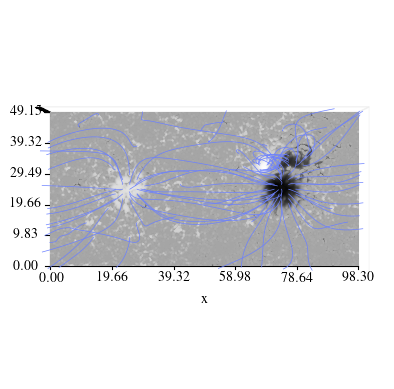

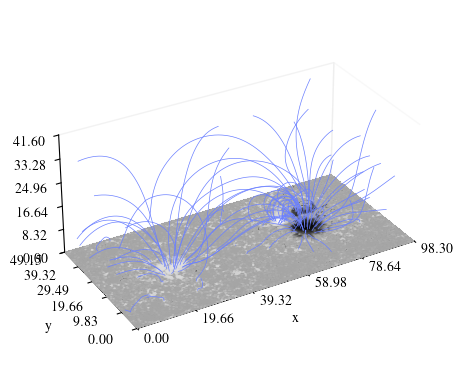

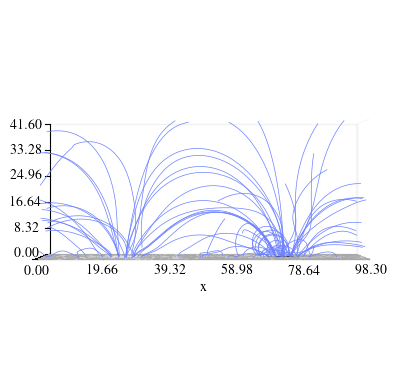

In [17]:
folder = "/Users/lilli/Desktop/Thesis/ISSIRMHD/Ref"

plot(Data3dref, "los", False, True, path=folder)
plot(Data3dref, "angular", False, True, path=folder)
plot(Data3dref, "side", False, True, path=folder)

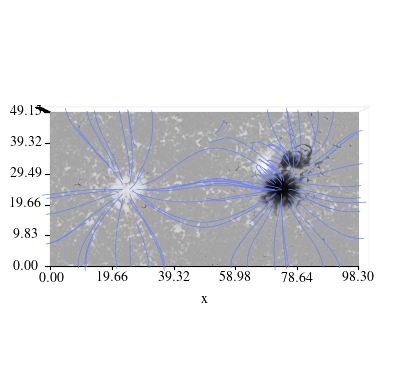

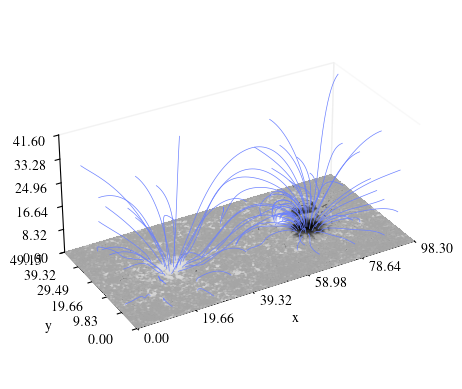

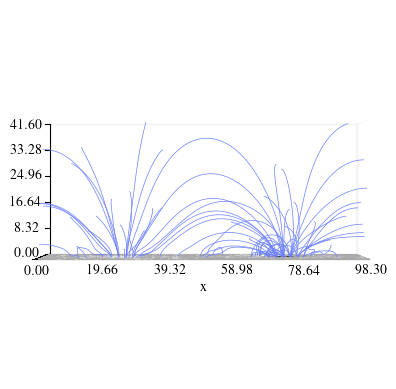

In [18]:
folder = "/Users/lilli/Desktop/Thesis/ISSIRMHD"

plot(data3dmhs2, "los", False, True, path=folder)
plot(data3dmhs2, "angular", False, True, path=folder)
plot(data3dmhs2, "side", False, True, path=folder)

In [12]:
from mhsflex.metrics import field_div_metric

field_div_metric(Data3dref, data3dmhs2)

/Users/lilli/Desktop/mflex/mhsflex/metrics.py:274: RuntimeWarning: divide by zero encountered in scalar divide
  temp = num / div
/Users/lilli/Desktop/mflex/mhsflex/metrics.py:274: RuntimeWarning: invalid value encountered in scalar divide
  temp = num / div


0.32710490769923456

In [10]:
temps = np.array((6000.0, 5500.0, 10000.0, 500000.0, 1000000.0, 1500000.0))  # Kelvin
heights = np.array((0.0, 0.5, 2.0, 2.2, 5.0, 100.0))

from mhsflex.field3d import (
    bpressure_linear,
    bdensity_linear,
    btemp_linear,
    fpressure_linear,
    fdensity_linear,
)

backtemp = btemp_linear(data3dmhs2, heights, temps)
backpres = bpressure_linear(data3dmhs2, heights, temps)
backden = bdensity_linear(data3dmhs2, heights, temps)

In [ ]:
fpres = fpressure_linear(data3dmhs2, heights, temps)
fden = fdensity_linear(data3dmhs2, heights, temps)

In [13]:
pres_3d = data3dref["p3d"] * 10**-1
den_3d = data3dref["d3d"] * 10**3

In [20]:
T_PHOTOSPHERE = 6000.0  # Photospheric temperature
T_CORONA = 1500000.0  # Coronal temperature

G_SOLAR = 272.2  # m/s^2
KB = 1.380649 * 10**-23  # Boltzmann constant in Joule/ Kelvin = kg m^2/(Ks^2)
MBAR = 1.67262 * 10**-27  # mean molecular weight (proton mass)

RHO0_1 = 2.7 * 10**-4  # plasma density at z = 0 in kg/(m^3)
P0_1 = T_PHOTOSPHERE * KB * RHO0_1 / MBAR  # plasma pressure in kg/(s^2 m)

P0_2 = pres_3d[0, :, :].max()
RHO0_2 = P0_2 * MBAR / (T_PHOTOSPHERE * KB)

MU0 = 1.25663706 * 10**-6  # permeability of free space in mkg/(s^2A^2)

L = 10**6  # Lengthscale Mm
T0 = 10000.0
H = KB * T0 / (MBAR * G_SOLAR) / L
B0 = data3dmhs2.field[
    :, :, 0, 2
].max()  # Gauss background magnetic field strength in 10^-4 kg/(s^2A) = 10^-4 T
PB0 = (B0 * 10**-4) ** 2 / (2 * MU0)  # magnetic pressure b0**2 / 2mu0 in kg/(s^2m)

BETA0_1 = P0_1 / PB0  # Plasma Beta, ration plasma to magnetic pressure

BETA0_2 = P0_2 / PB0  # Plasma Beta, ration plasma to magnetic pressure

print(BETA0_1, BETA0_2)

0.3186185017644207 4.332930817054833


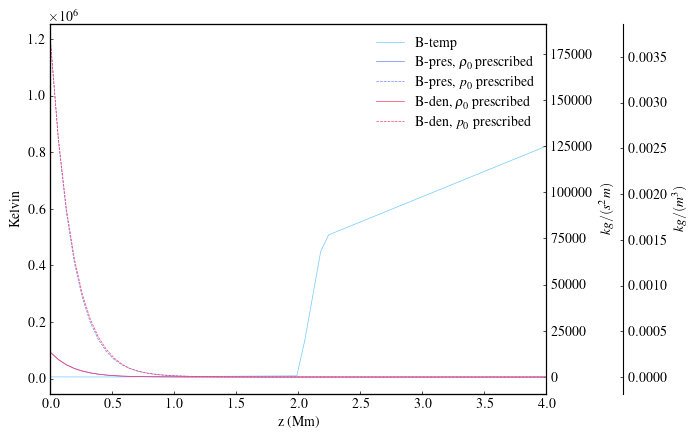

In [74]:
fig, ax1 = plt.subplots()

ax1.plot(
    data2d.z,
    backtemp,
    linewidth=0.5,
    color=c1,
    label=r"B-temp",
)

ax1.set_ylabel("Kelvin")

ax1.set_xlabel("z (Mm)")

ax1.set_xlim(0, 4.0)

ax2 = ax1.twinx()

ax2.plot(
    data2d.z,
    BETA0_1 / 2.0 * backpres * (B0 * 10**-4) ** 2.0 / MU0,
    linewidth=0.5,
    color=c2,
    label=r"B-pres, $\rho_0$ prescribed",
)

ax2.plot(
    data2d.z,
    BETA0_2 / 2.0 * backpres * (B0 * 10**-4) ** 2.0 / MU0,
    linewidth=0.5,
    color=c2,
    linestyle="dashed",
    label=r"B-pres, $p_0$ prescribed ",
)

ax2.set_ylabel(r"$kg/(s^2 m)$")

ax3 = ax1.twinx()

ax3.plot(
    data2d.z,
    BETA0_1
    / (2.0 * H)
    * T0
    / T_PHOTOSPHERE
    * backden
    * (B0 * 10**-4) ** 2.0
    / (MU0 * G_SOLAR * L),
    linewidth=0.5,
    color=c4,
    label=r"B-den, $\rho_0$ prescribed ",
)

ax3.plot(
    data2d.z,
    BETA0_2
    / (2.0 * H)
    * T0
    / T_PHOTOSPHERE
    * backden
    * (B0 * 10**-4) ** 2.0
    / (MU0 * G_SOLAR * L),
    linewidth=0.5,
    color=c4,
    linestyle="dashed",
    label=r"B-den, $p_0$ prescribed ",
)

ax3.spines["right"].set_position(("outward", 55))

ax3.set_ylabel(r"$kg /(m^3)$")
# ax1.legend(frameon=False, loc='center left', bbox_to_anchor=(1.1, 0.8))
# ax2.legend(frameon=False, loc ='center left', bbox_to_anchor=(1.1, 0.55))
# ax3.legend(frameon=False, loc ='center left', bbox_to_anchor=(1.1, 0.35))

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines3, labels3 = ax3.get_legend_handles_labels()

lines = lines1 + lines2 + lines3
labels = labels1 + labels2 + labels3
plt.legend(lines, labels, frameon=False, loc=1)

ax1.tick_params(direction="in", length=2, width=0.5)
ax2.tick_params(direction="in", length=2, width=0.5)
ax3.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/batm.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [16]:
dp_max_arr = np.zeros_like(z_arr)

for iz in range(nresol_z):
    dp_max_arr[iz] = data3dmhs2.dpressure[:, :, iz].min()

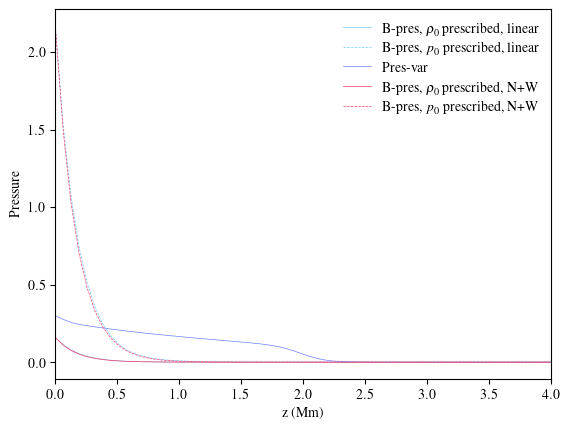

In [75]:
fig, ax1 = plt.subplots()

ax1.plot(
    data2d.z,
    BETA0_1 / 2.0 * backpres,
    linewidth=0.5,
    color=c1,
    label=r"B-pres, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    BETA0_2 / 2.0 * backpres,
    linewidth=0.5,
    color=c1,
    linestyle="dashed",
    label=r"B-pres, $p_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    -dp_max_arr,
    linewidth=0.5,
    color=c2,
    label="Pres-var",
)
ax1.plot(
    data2d.z,
    BETA0_1 / 2.0 * data3dmhs2.bpressure,
    linewidth=0.5,
    color=c4,
    label=r"B-pres, $\rho_0$ prescribed, N+W",
)
ax1.plot(
    data2d.z,
    BETA0_2 / 2.0 * data3dmhs2.bpressure,
    linewidth=0.5,
    color=c4,
    linestyle="dashed",
    label=r"B-pres, $p_0$ prescribed, N+W",
)
ax1.set_ylabel("Pressure")
ax1.set_xlabel("z (Mm)")
plt.legend(frameon=False)
ax1.set_xlim(0, 4.0)
plotname = folder + "/maxdp.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [18]:
dd_max_arr = np.zeros_like(z_arr)

for iz in range(nresol_z):
    dd_max_arr[iz] = data3dmhs2.ddensity[:, :, iz].min()

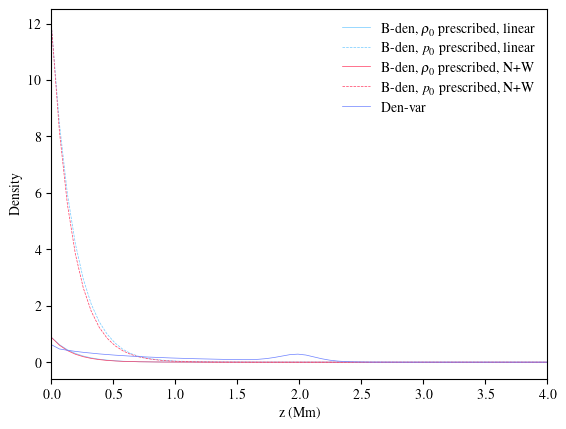

In [76]:
fig, ax1 = plt.subplots()

ax1.plot(
    data2d.z,
    BETA0_1 / (2.0 * H) * T0 / T_PHOTOSPHERE * backden,
    linewidth=0.5,
    color=c1,
    label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    BETA0_2 / (2.0 * H) * T0 / T_PHOTOSPHERE * backden,
    linewidth=0.5,
    color=c1,
    linestyle="dashed",
    label=r"B-den, $p_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    BETA0_1 / (2.0 * H) * T0 / T_PHOTOSPHERE * data3dmhs2.bdensity,
    linewidth=0.5,
    color=c4,
    label=r"B-den, $\rho_0$ prescribed, N+W",
)
ax1.plot(
    data2d.z,
    BETA0_2 / (2.0 * H) * T0 / T_PHOTOSPHERE * data3dmhs2.bdensity,
    linewidth=0.5,
    color=c4,
    linestyle="dashed",
    label=r"B-den, $p_0$ prescribed, N+W",
)
ax1.plot(
    data2d.z,
    -dd_max_arr,
    linewidth=0.5,
    color=c2,
    label="Den-var",
)
ax1.set_ylabel("Density")
ax1.set_xlabel("z (Mm)")
plt.legend(frameon=False)
ax1.set_xlim(0, 4.0)
plotname = folder + "/maxdd.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [30]:
bp_matrix_p = np.zeros_like(data3dmhs2.dpressure)
bp_matrix_rho = np.zeros_like(data3dmhs2.dpressure)
bp_matrix_p[:, :, :] = backpres
bp_matrix_rho[:, :, :] = backpres

fp_rho = (
    (BETA0_1 / 2.0 * bp_matrix_rho + data3dmhs2.dpressure) * (B0 * 10**-4) ** 2.0 / MU0
)

fp_p = (BETA0_2 / 2.0 * bp_matrix_p + data3dmhs2.dpressure) * (B0 * 10**-4) ** 2.0 / MU0

In [66]:
pres_3d = data3dref["p3d"] * 10**-1
den_3d = data3dref["d3d"] * 10**3

In [67]:
fp_ISSI_max = np.zeros_like(z_arr)
fp_ISSI_min = np.zeros_like(z_arr)

fp_rho_max = np.zeros_like(z_arr)
fp_rho_min = np.zeros_like(z_arr)

fp_p_max = np.zeros_like(z_arr)
fp_p_min = np.zeros_like(z_arr)

for iz in range(nresol_z):
    fp_ISSI_max[iz] = pres_3d[iz, :, :].max()
    fp_ISSI_min[iz] = pres_3d[iz, :, :].min()
    fp_rho_max[iz] = fp_rho[:, :, iz].max()
    fp_rho_min[iz] = fp_rho[:, :, iz].min()
    fp_p_max[iz] = fp_p[:, :, iz].max()
    fp_p_min[iz] = fp_p[:, :, iz].min()

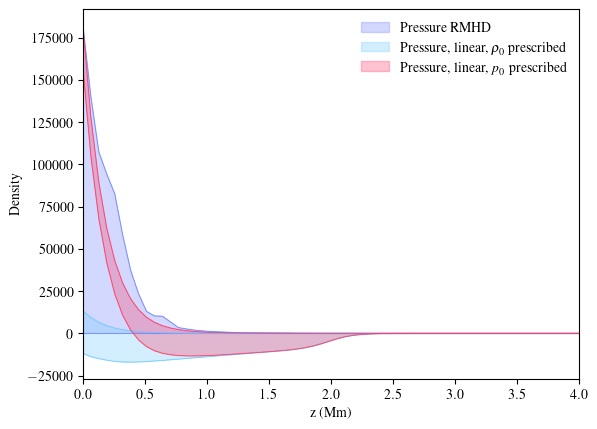

In [81]:
fig, ax1 = plt.subplots()

ax1.plot(
    data2d.z,
    fp_ISSI_max,
    linewidth=0.5,
    color=c2,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    fp_ISSI_min,
    linewidth=0.5,
    color=c2,
    # label=r"B-den, $p_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    fp_rho_max,
    linewidth=0.5,
    color=c1,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    fp_rho_min,
    linewidth=0.5,
    color=c1,
    # label=r"B-den, $p_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    fp_p_max,
    linewidth=0.5,
    color=c4,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    fp_p_min,
    linewidth=0.5,
    color=c4,
    # label=r"B-den, $p_0$ prescribed, linear",
)

ax1.fill_between(data2d.z, fp_ISSI_min, fp_ISSI_max, color=c2, alpha=0.3, label=r"Pressure RMHD")
ax1.fill_between(data2d.z, fp_rho_min, fp_rho_max, color=c1, alpha=0.3, label=r"Pressure, linear, $\rho_0$ prescribed")
ax1.fill_between(data2d.z, fp_p_min, fp_p_max, color=c4, alpha=0.3, label=r"Pressure, linear, $p_0$ prescribed")
ax1.set_ylabel("Density")
ax1.set_xlabel("z (Mm)")
plt.legend(frameon=False)
ax1.set_xlim(0, 4.0)
plotname = folder + "/rangep.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [69]:
bd_matrix_p = np.zeros_like(data3dmhs2.ddensity)
bd_matrix_rho = np.zeros_like(data3dmhs2.ddensity)
bd_matrix_p[:, :, :] = backden
bd_matrix_rho[:, :, :] = backden

fd_rho = (
    (BETA0_1 / (2.0 * H) * T0 / T_PHOTOSPHERE * bd_matrix_rho + data3dmhs2.ddensity)
    * (B0 * 10**-4) ** 2.0
    / (MU0 * G_SOLAR * L)
)

fd_p = (
    (BETA0_2 / (2.0 * H) * T0 / T_PHOTOSPHERE * bd_matrix_p + data3dmhs2.ddensity)
    * (B0 * 10**-4) ** 2.0
    / (MU0 * G_SOLAR * L)
)

In [70]:
fd_ISSI_max = np.zeros_like(z_arr)
fd_ISSI_min = np.zeros_like(z_arr)

fd_rho_max = np.zeros_like(z_arr)
fd_rho_min = np.zeros_like(z_arr)

fd_p_max = np.zeros_like(z_arr)
fd_p_min = np.zeros_like(z_arr)

for iz in range(nresol_z):
    fd_ISSI_max[iz] = den_3d[iz, :, :].max()
    fd_ISSI_min[iz] = den_3d[iz, :, :].min()
    fd_rho_max[iz] = fd_rho[:, :, iz].max()
    fd_rho_min[iz] = fd_rho[:, :, iz].min()
    fd_p_max[iz] = fd_p[:, :, iz].max()
    fd_p_min[iz] = fd_p[:, :, iz].min()

Python(12935) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12936) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12937) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12938) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12939) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12940) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12941) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12942) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(12943) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


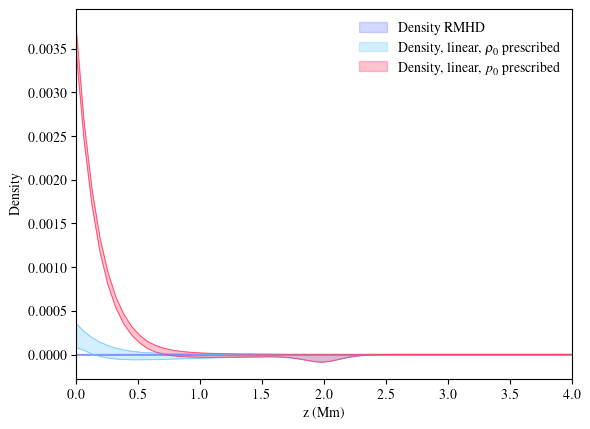

In [79]:
fig, ax1 = plt.subplots()

ax1.plot(
    data2d.z,
    fd_ISSI_max,
    linewidth=0.5,
    color=c2,
    #label=r"Den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    fd_ISSI_min,
    linewidth=0.5,
    color=c2,
    #label=r"en, $p_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    fd_rho_max,
    linewidth=0.5,
    color=c1,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    fd_rho_min,
    linewidth=0.5,
    color=c1,
    # label=r"B-den, $p_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    fd_p_max,
    linewidth=0.5,
    color=c4,
    # label=r"B-den, $\rho_0$ prescribed, linear",
)
ax1.plot(
    data2d.z,
    fd_p_min,
    linewidth=0.5,
    color=c4,
    # label=r"B-den, $p_0$ prescribed, linear",
)

ax1.fill_between(data2d.z, fd_ISSI_min, fd_ISSI_max, color=c2, alpha=0.3, label=r"Density RMHD")
ax1.fill_between(data2d.z, fd_rho_min, fd_rho_max, color=c1, alpha=0.3, label=r"Density, linear, $\rho_0$ prescribed")
ax1.fill_between(data2d.z, fd_p_min, fd_p_max, color=c4, alpha=0.3, label=r"Density, linear, $p_0$ prescribed")
ax1.set_ylabel("Density")
ax1.set_xlabel("z (Mm)")
plt.legend(frameon=False)
ax1.set_xlim(0, 4.0)
plotname = folder + "/ranged.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [72]:
print(fd_ISSI_max.max(), fd_ISSI_min.min())
print(fd_rho_max.max(), fd_rho_min.min())
print(fd_p_max.max(), fd_p_min.min())

4.4585658542928286e-07 1.9440819625716923e-16
0.00035670316892936896 -8.773561645746358e-05
0.0037584652107639526 -8.756578074963484e-05


In [73]:
print(fp_ISSI_max.max(), fp_ISSI_min.min())
print(fp_rho_max.max(), fp_rho_min.min())
print(fp_p_max.max(), fp_p_min.min())

181849.359375 0.0011467606527730823
13372.142985256665 -16998.14450381514
181849.35937500003 -13319.910985227345


In [ ]:
for ix in range(0, nresol_x, 5):
    for iy in range(0, nresol_y, 5):
        # for ix in range(nresol_x):
        #     for iy in range(nresol_y):
        plt.plot(
            z_arr[0:650],
            BETA0_1 / 2.0 * backpres * (B0 * 10**-4) ** 2.0 / MU0
            + data3dmhs2.dpressure[iy, ix, 0:650] * (B0 * 10**-4) ** 2.0 / MU0,
            linewidth=0.2,
            color=c4,
            alpha=0.5,
        )
        # plt.plot(
        #     z_arr[0:650],
        #     BETA0_2 / 2.0 * backpres * (B0 * 10**-4) ** 2.0 / MU0
        #     + data3dmhs2.dpressure[iy, ix, 0:650] * (B0 * 10**-4) ** 2.0 / MU0,
        #     linewidth=0.2,
        #     color=c1,
        #     alpha=0.5,
        # )
        # plt.plot(
        #     z_arr[0:650],
        #     pres_3d[0:650, iy, ix],
        #     linewidth=0.2,
        #     color=c2,
        #     # linestyle="dashed",
        #     alpha=0.5,
        # )
# plt.plot(
#     z_arr[0:650],
#     BETA0 / 2.0 * backpres * (B0 * 10**-4) ** 2.0 / MU0,
#     linewidth=2.0,
#     color="black",
#     alpha=0.5,
# )
plt.ylabel("$kg/(s^2 m)$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.xlim([0, 4])
plt.tick_params(direction="in", length=2, width=0.5)
# plotname = folder + "/dpres_mhs2.png"
# plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [ ]:
for ix in range(0, nresol_x, 4):
    for iy in range(0, nresol_y, 4):
        plt.plot(
            z_arr[0:650],
            BETA0
            / (2.0 * H)
            * T0
            / T_PHOTOSPHERE
            * backden
            * (B0 * 10**-4) ** 2.0
            / (MU0 * G_SOLAR * L)
            + data3dmhs2.ddensity[iy, ix, 0:650]
            * (B0 * 10**-4) ** 2.0
            / (MU0 * G_SOLAR * L),
            linewidth=0.2,
            color=c4,
            alpha=0.5,
        )
        plt.plot(
            z_arr[0:650],
            den_3d[0:650, iy, ix],
            linewidth=0.2,
            color=c2,
            # linestyle="dashed",
            alpha=0.5,
        )
# plt.plot(
#     z_arr[0:650],
#     BETA0
#     / (2.0 * H)
#     * T0
#     / T_PHOTOSPHERE
#     * backden
#     * (B0 * 10**-4) ** 2.0
#     / (MU0 * G_SOLAR * L),
#     linewidth=2.0,
#     color="black",
#     alpha=0.5,
# )
plt.ylabel("$kg/m^3$")
plt.xlabel("z")
plt.legend(frameon=False)
plt.xlim([0, 4])
plt.tick_params(direction="in", length=2, width=0.5)
plotname = folder + "/dden_mhs2.png"
plt.savefig(plotname, dpi=600, bbox_inches="tight", pad_inches=0.1)
plt.show()